In [1]:
import os
import sys
# import re
import pickle
from collections import defaultdict, OrderedDict, Counter
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
# from pandas.plotting import scatter_matrix
# from pandas_profiling import ProfileReport
# from missingno import dendrogram
# import missingno as msno

# pd.options.display.float_format = '{:0.5f}'.format`

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(20, 10)})
plt.rc('font',family='Malgun Gothic')

# 01. 소방청 구급활동현황

## 01-1. EDA

In [4]:
raw_data = pd.read_csv('data/소방청_구급활동현황_20181231.csv', encoding='cp949')

In [5]:
raw_data[raw_data.columns[-9:-4]]

,환자증상1,환자증상2,질병외_교통사고,질병외_사고부상,질병외_비외상성손상
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
689669,두통,기타통증,NaN,낙상,NaN
689670,기타통증,NaN,NaN,NaN,NaN
689671,의식장애,호흡곤란,NaN,NaN,NaN
689672,열상,NaN,운전자,NaN,NaN


In [6]:
cond1 = raw_data['질병외_교통사고'].notnull()
# cond2 = raw_data['질병외_사고부상'].notnull()
cond2 = raw_data['질병외_비외상성손상'].notnull()
raw_data[cond1 & cond2]

,집계년도,시군명,출동소방서,출동안전센터_지역대,신고년월일,신고시각,접수경로,관할구분,출동년월일,출동시각,...,외국인유무,환자증상1,환자증상2,질병외_교통사고,질병외_사고부상,질병외_비외상성손상,의식상태,구급대원1_자격,구급대원2_자격,운전요원_자격


In [7]:
raw_data['질병외_교통사고'].value_counts()

운전자       16631
동승자       12627
보행자        8918
오토바이사고     8865
자전거사고      4915
기타탈것       1403
미상          237
Name: 질병외_교통사고, dtype: int64

In [8]:
raw_data['질병외_비외상성손상'].value_counts()

중독         2576
연기흡입       1351
목맴/목졸림     1153
(구)온열손상     574
기타(질병외)     270
질식          264
화상          184
화학물질        104
익수           65
한랭손상         43
임산부           1
Name: 질병외_비외상성손상, dtype: int64

In [9]:
raw_data['질병외_사고부상'].value_counts()

낙상          54927
기타(사고부상)    12981
열상          11981
상해          11228
기타 둔상        5377
추락           4544
동물/곤충        2319
기계           2007
중독           1628
물             946
자상            943
화염            370
질식            318
고온체           274
동물/곤충기타       150
익수            140
전기사고          139
농기계           125
온열손상          107
관통상            97
화학물질           90
성폭행            16
자연재해            1
Name: 질병외_사고부상, dtype: int64

# 02. 소방출동데이터

In [10]:
data = pd.read_csv('소방출동데이터.csv')

In [11]:
data.head().T

,0,1,2,3,4
출동소방서,양평소방서,광주소방서,수원남부소방서,군포소방서,수원남부소방서
출동안전센터_지역대,양평수난구조대,초월119안전센터,매산119안전센터,산본119안전센터,지만119안전센터
신고년월일,2018-01-02,2018-01-05,2018-01-01,2018-01-11,2018-01-12
신고시각,2022-11-22 11:45:00,2022-11-22 18:30:00,2022-11-22 08:32:00,2022-11-22 10:22:00,2022-11-22 21:32:00
신고요일,Tuesday,Friday,Monday,Thursday,Friday
...,...,...,...,...,...
현장과의거리,10.0,3.2,2.8,1.0,1.1
환자연령대,NaN,NaN,NaN,NaN,40대
환자성별,NaN,NaN,NaN,NaN,남
긴급구조구,남양주시,광주시,수원시 팔달구,군포시,수원시 장안구


## 02-1. 지역별출동건수.csv 도출

In [12]:
k = data.groupby('긴급구조구')['신고시각'].count().sort_values(ascending=False).reset_index()

In [13]:
key = k['긴급구조구']
value = k['긴급구조구'].str.split().str[0][:]

In [14]:
mapping = {k:v for k, v in zip(key, value)}
for i, k in enumerate(mapping.keys()):
    if i >= 42:
        mapping[k] = None

In [15]:
data['긴급구조구'] = data['긴급구조구'].map(mapping)

In [16]:
s = data.groupby('긴급구조구')['신고시각'].count().sort_values(ascending=False).reset_index()

In [17]:
s

,긴급구조구,신고시각
0,수원시,51322
1,성남시,42876
2,고양시,41576
3,부천시,35474
4,용인시,35283
...,...,...
26,여주시,6629
27,가평군,6489
28,의왕시,5911
29,연천군,3792


In [18]:
s.columns = ['지역', '건수']
# s.to_csv('지역별출동건수.csv', index=False)

# 03. 호출건수와 지역과의 관계가 있는 요소 파악

## 03-1. 데이터 불러오기

In [95]:
지역별가구비율 = pd.read_csv('지역별가구비율.csv')

In [96]:
지역소방대상물별 = pd.read_csv('data/지역소방대상물별.csv')

In [97]:
기초수급자 = pd.read_csv('기초수급자.csv').iloc[:,1:]

In [98]:
독거노인비율 = pd.read_csv('독거노인비율.csv').iloc[:,1:][['지역','총인구수','독거노인/노인','노인/전체']]

In [99]:
지역별대원수 = pd.read_csv('지역별대원수.csv')

In [107]:
지역별대원수.columns = ['지역', '정원(명)']

In [101]:
Y = pd.read_csv('지역별출동건수.csv')
Y.columns = ['지역', '건수']

In [106]:
지역별대원수

,시군명,정원(명)
0,가평군,226
1,고양시,625
2,과천시,150
3,광명시,218
4,광주시,306
...,...,...
26,파주시,391
27,평택시,549
28,포천시,370
29,하남시,208


## 03-2. 데이터 합치기

In [117]:
df = pd.merge(지역별가구비율, 독거노인비율, on='지역')
df = pd.merge(df, 지역별대원수, on='지역')
df = pd.merge(df, Y, on='지역')

In [118]:
df.head().T

,0,1,2,3,4
지역,가평군,고양시,과천시,광명시,광주시
1인/가구당,33.271315,22.856842,18.240711,22.068394,22.625609
2인/가구당,32.725287,25.887038,24.461934,26.038126,28.609487
3인/가구당,17.54166,24.452592,25.784345,24.238594,23.278271
4인/가구당,10.948876,20.772585,24.16747,21.611465,18.831774
...,...,...,...,...,...
총인구수,63936.0,1056853.0,58325.0,333114.0,376819.0
독거노인/노인,0.304307,0.230434,0.194366,0.231563,0.215665
노인/전체,0.23206,0.119979,0.133288,0.120085,0.113946
정원(명),226,625,150,218,306


In [119]:
df['지역1인당호출건수'] = df['건수'] / df['총인구수']

## 03-3. 데이터 상관관계 시각화

<AxesSubplot:>

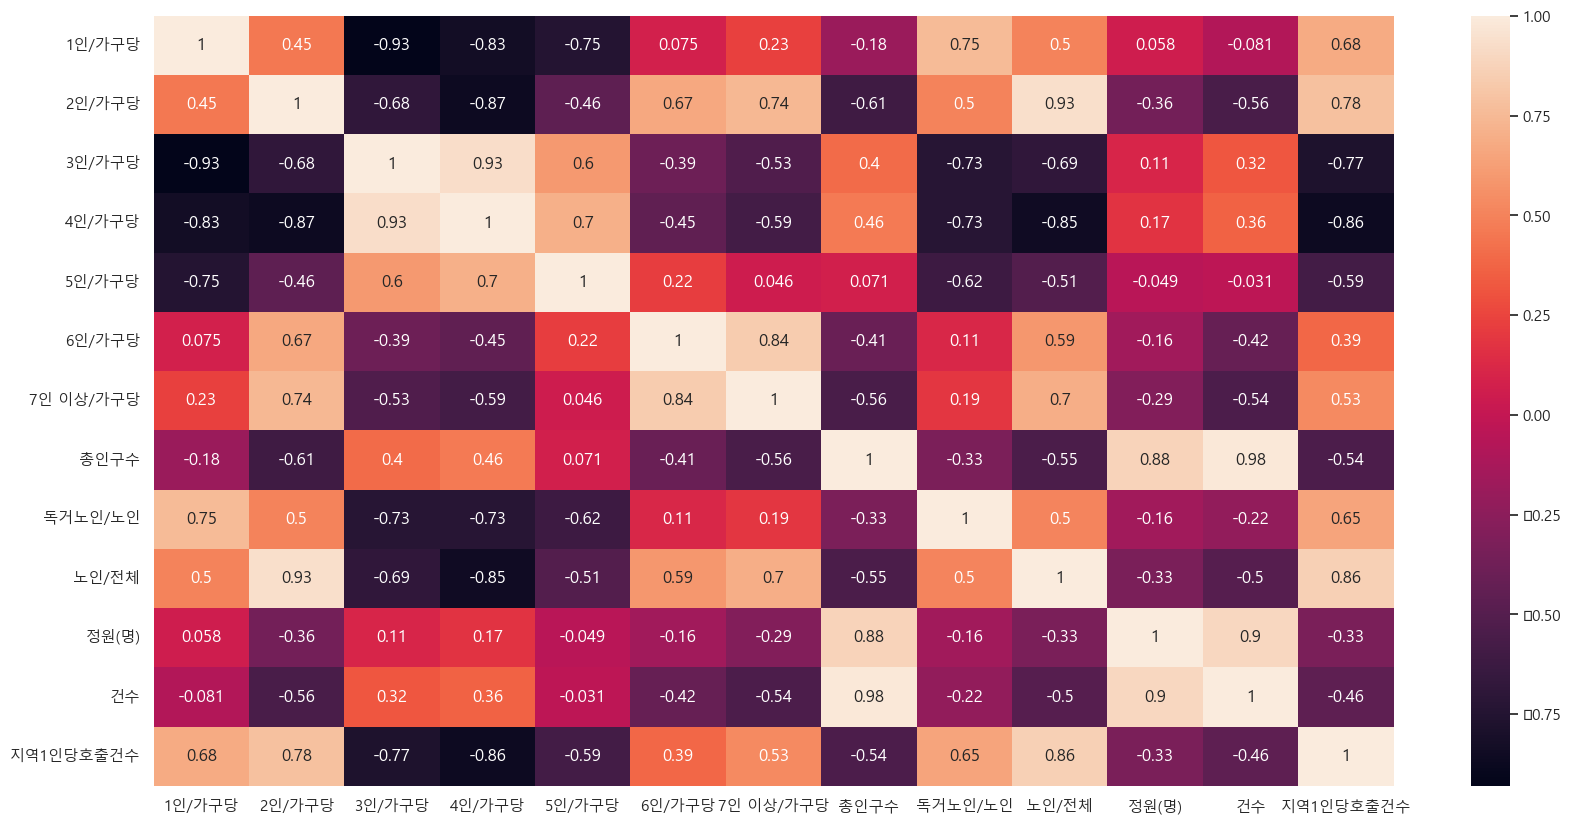

In [120]:
sns.heatmap(df.corr(), annot=True)

## 03-4. 호출건수과 다양한 요소와의 상관관계

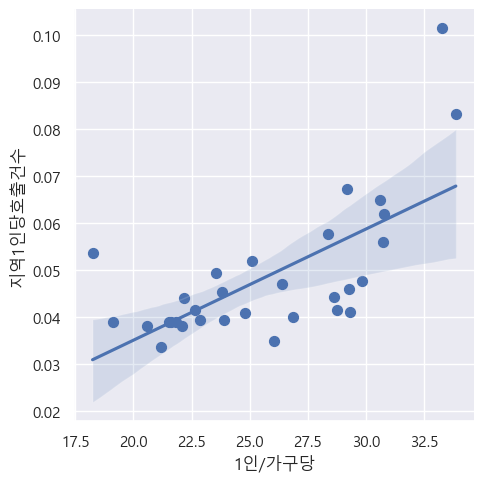

In [136]:
sns.set(rc={'figure.figsize':(20, 10)})
plt.rc('font',family='Malgun Gothic')
sns.lmplot(
    data=df, x="1인/가구당", y="지역1인당호출건수",palette="muted",
    # ci=None,
    scatter_kws={"s": 50, "alpha": 1}
);

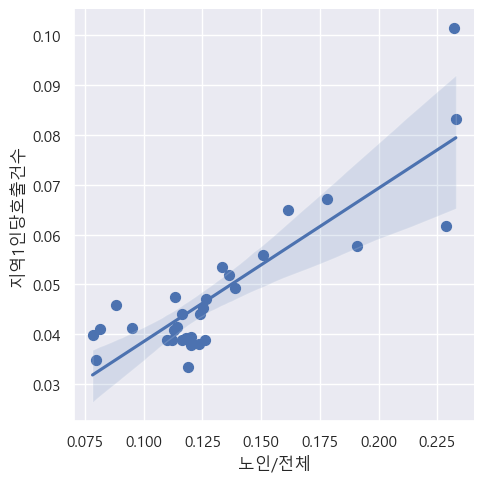

In [137]:
sns.set(rc={'figure.figsize':(20, 10)})
plt.rc('font',family='Malgun Gothic')
sns.lmplot(
    data=df, x="노인/전체", y="지역1인당호출건수",palette="muted",
    # ci=None,
    scatter_kws={"s": 50, "alpha": 1}
);

In [28]:
df.head(3).T

,0,1,2
지역,가평군,고양시,과천시
1인/가구당,33.271315,22.856842,18.240711
2인/가구당,32.725287,25.887038,24.461934
3인/가구당,17.54166,24.452592,25.784345
4인/가구당,10.948876,20.772585,24.16747
...,...,...,...
7인 이상/가구당,0.40851,0.258033,0.422957
총인구수,63936.0,1056853.0,58325.0
독거노인/노인,0.304307,0.230434,0.194366
노인/전체,0.23206,0.119979,0.133288


# 데이터 모델링

In [29]:
model_df = df.iloc[:,1:]

In [30]:
x = model_df.iloc[:,:-1]
y = model_df.iloc[:,-1]

In [31]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
minmax = MinMaxScaler()
scaled = minmax.fit_transform(x)

In [33]:
# poly = PolynomialFeatures(2)
# scaled = PolynomialFeatures.fit_transform(scaled)


In [34]:
scaled

array([[0.9626291 , 0.9524631 , 0.05038491, 0.        , 0.        ,
        0.51579789, 0.55286839, 0.01531833, 0.83720708, 0.99438043],
       [0.29563827, 0.30099936, 0.84657272, 0.74317356, 0.39365977,
        0.29712509, 0.12258244, 0.84509605, 0.35756436, 0.27015954],
       [0.        , 0.16523303, 1.        , 1.        , 0.96323548,
        0.35580586, 0.59418079, 0.01062923, 0.12338267, 0.35615502],
       [0.24514245, 0.3153931 , 0.82191861, 0.80663566, 0.44713846,
        0.17499877, 0.02704282, 0.24026956, 0.36489907, 0.27084558],
       [0.28082904, 0.56036057, 0.71128264, 0.59634919, 0.58550587,
        0.56509592, 0.45430262, 0.2767937 , 0.26167261, 0.23117763],
       [0.25044986, 0.25910754, 0.84383879, 0.81494824, 0.48649601,
        0.32985839, 0.18441369, 0.13318586, 0.76233362, 0.24623635],
       [0.22842654, 0.26802167, 0.84650793, 0.84406216, 0.46655249,
        0.08851408, 0.1812311 , 0.19912152, 0.36470341, 0.21905641],
       [0.21039842, 0.33102053, 0.7934704

In [35]:
# poly = PolynomialFeatures(2)

In [36]:
linear = LinearRegression()

In [37]:
linear.fit(x[:-3], y[:-3])

LinearRegression()

In [38]:
train_pred = linear.predict(x[:-3])
test_pred = linear.predict(x[-3:])

print(mean_squared_error(train_pred, y[:-3]))
print(mean_squared_error(test_pred, y[-3:]))

1848514.7554367022
4598337.04483203


In [39]:
y

0      6489
1     41576
2      3122
3     12627
4     15621
5      9031
6     11035
7     17209
8     26802
9      6693
10    35474
11    42876
12    51322
13    19287
14    32835
15    10879
16    22660
17    11045
18     7270
19     6629
20     3792
21     9427
22    35283
23     5911
24    23414
25    10416
26    20972
27    24628
28    10600
29    10092
30    27718
Name: 건수, dtype: int64

In [40]:
pred_y = list(train_pred) + list(test_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


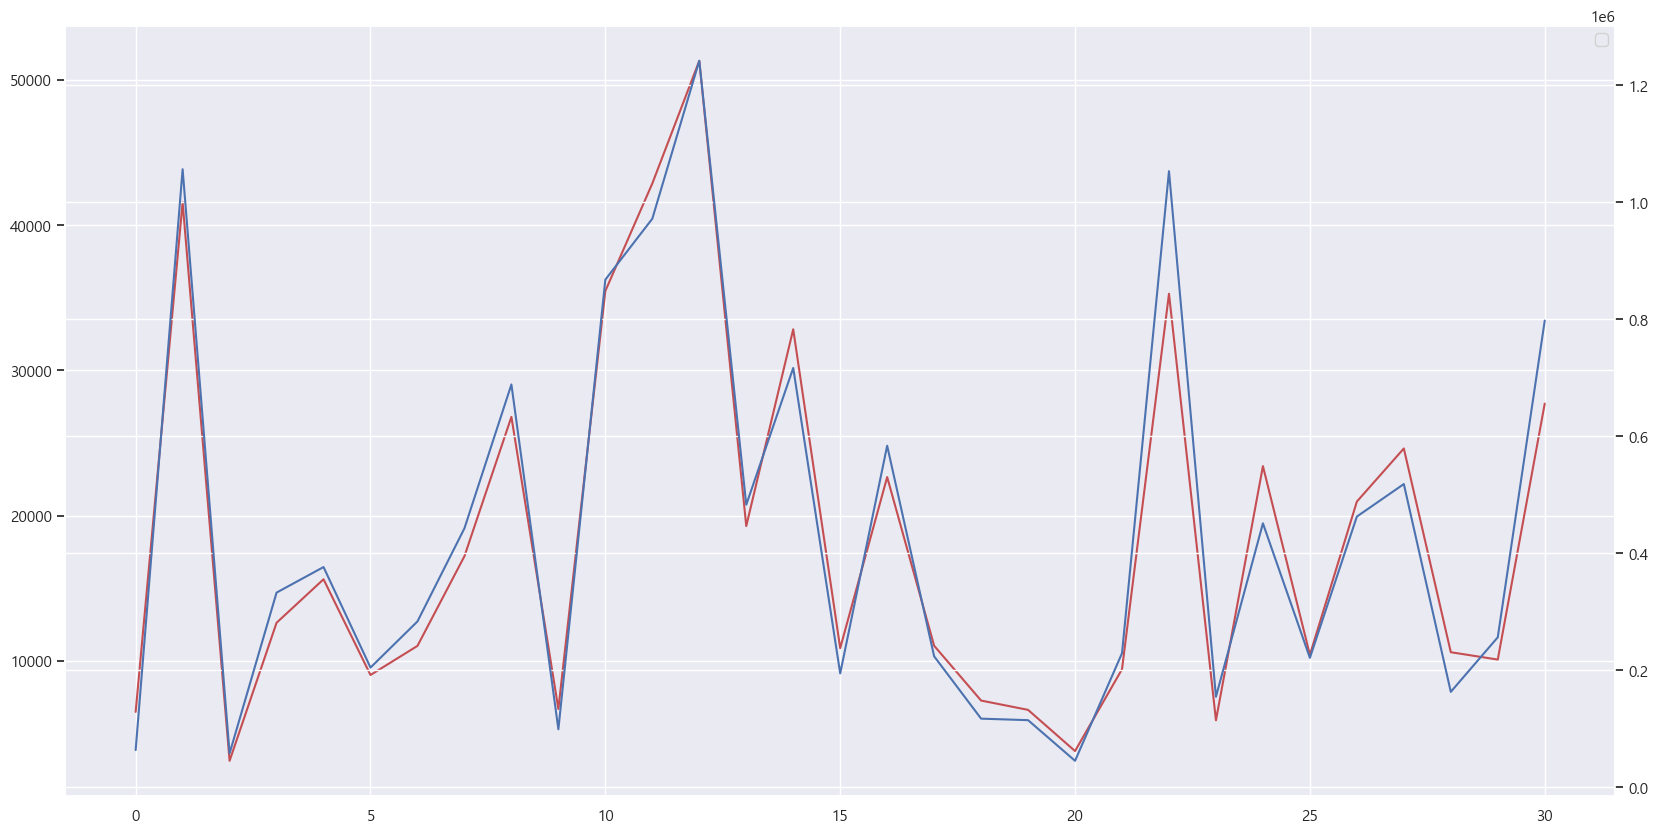

In [41]:
# plt.plot(pred_y)
plt.plot(y, color='r')

y_right = plt.twinx()
y_right.plot(df['총인구수'], color='b')
plt.legend()
plt.show()

In [42]:
linear.score(x, y)

0.9867972266987116

In [43]:
len(train_pred)

28

# 데이터 정의

In [44]:
per_df = pd.read_csv('소방관서1인당담당인구현황.csv', encoding='cp949')

In [45]:
per_df.columns

Index(['시군명', '관서명', '정원(명)', '관할인구(명)', '1인당담당인구(명)'], dtype='object')

In [46]:
per_df.head(3)

,시군명,관서명,정원(명),관할인구(명),1인당담당인구(명)
0,수원시,수원소방서,285,637257,2236
1,수원시,수원남부소방서,303,546457,1803
2,성남시,성남소방서,315,446765,1418


In [47]:
per_df['시군명'].nunique()

31

In [48]:
per_df = per_df.groupby('시군명').sum().reset_index()
per_df.columns = ['지역', '정원(명)', '관할인구(명)', '1인당담당인구(명)']

In [49]:
per_df.columns[-1]

'1인당담당인구(명)'

In [50]:
per_df.head(3)

,지역,정원(명),관할인구(명),1인당담당인구(명)
0,가평군,226,62264,276
1,고양시,625,1079353,3449
2,과천시,150,73345,489


In [51]:
per_df

,지역,정원(명),관할인구(명),1인당담당인구(명)
0,가평군,226,62264,276
1,고양시,625,1079353,3449
2,과천시,150,73345,489
3,광명시,218,292893,1344
4,광주시,306,387289,1266
...,...,...,...,...
26,파주시,391,483245,1236
27,평택시,549,564288,2045
28,포천시,370,148939,403
29,하남시,208,320087,1539


<AxesSubplot:xlabel='지역', ylabel='1인당담당인구(명)'>

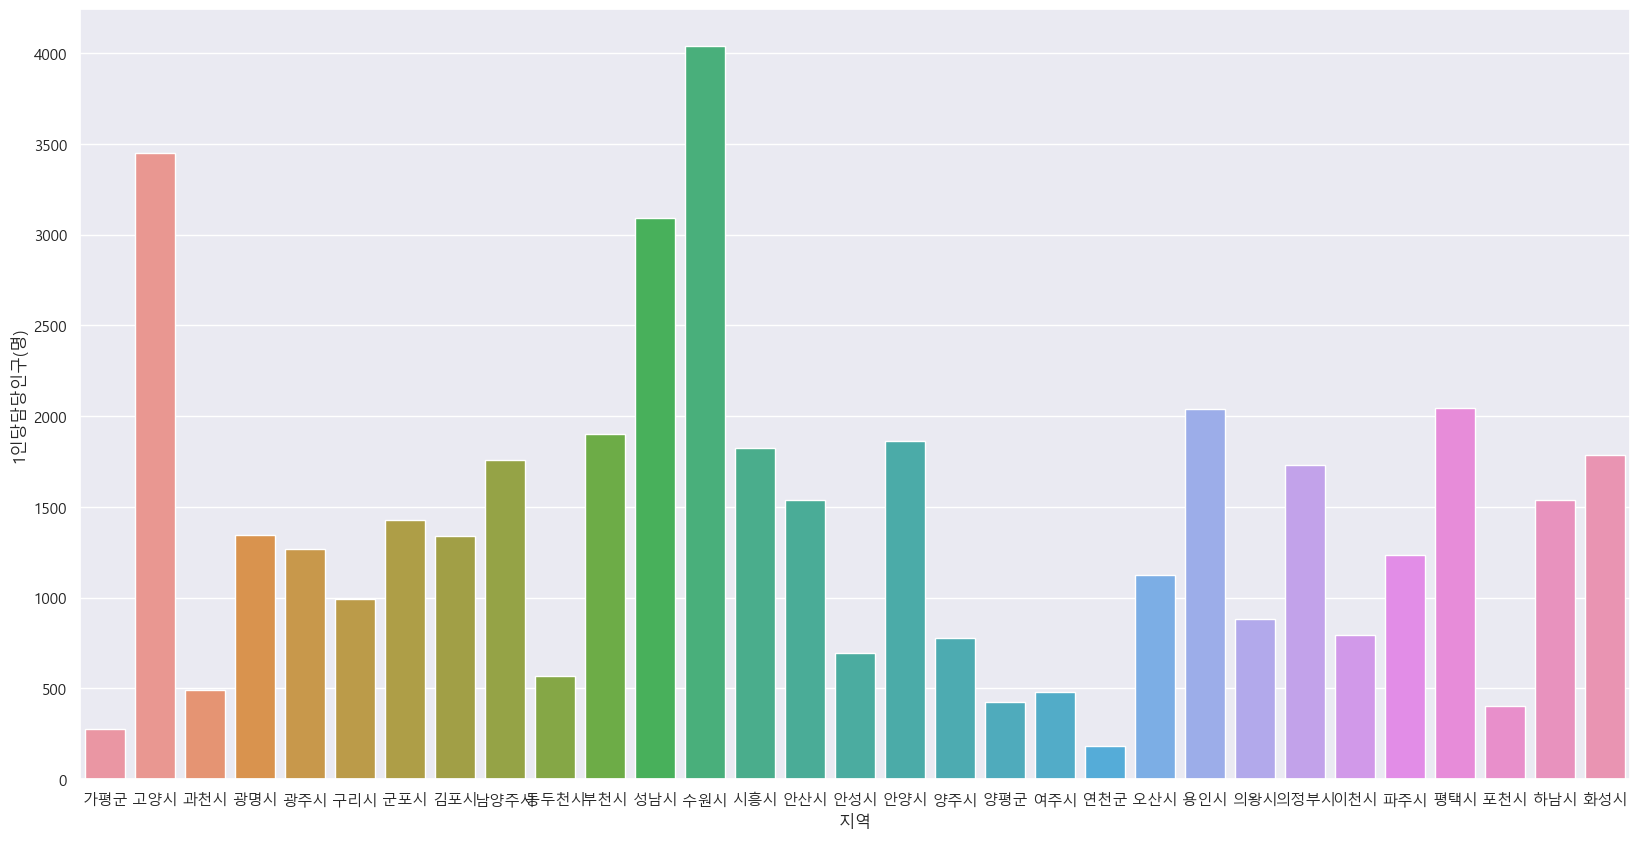

In [52]:
sns.barplot(data=per_df, x='지역', y='1인당담당인구(명)')

In [53]:
f = pd.merge(df, per_df, on='지역')

In [54]:
f.columns

Index(['지역', '1인/가구당', '2인/가구당', '3인/가구당', '4인/가구당', '5인/가구당', '6인/가구당',
       '7인 이상/가구당', '총인구수', '독거노인/노인', '노인/전체', '건수', '정원(명)', '관할인구(명)',
       '1인당담당인구(명)'],
      dtype='object')

In [55]:
f['1인당출동건수'] = f['건수'] / f['정원(명)']

<AxesSubplot:xlabel='지역', ylabel='1인당출동건수'>

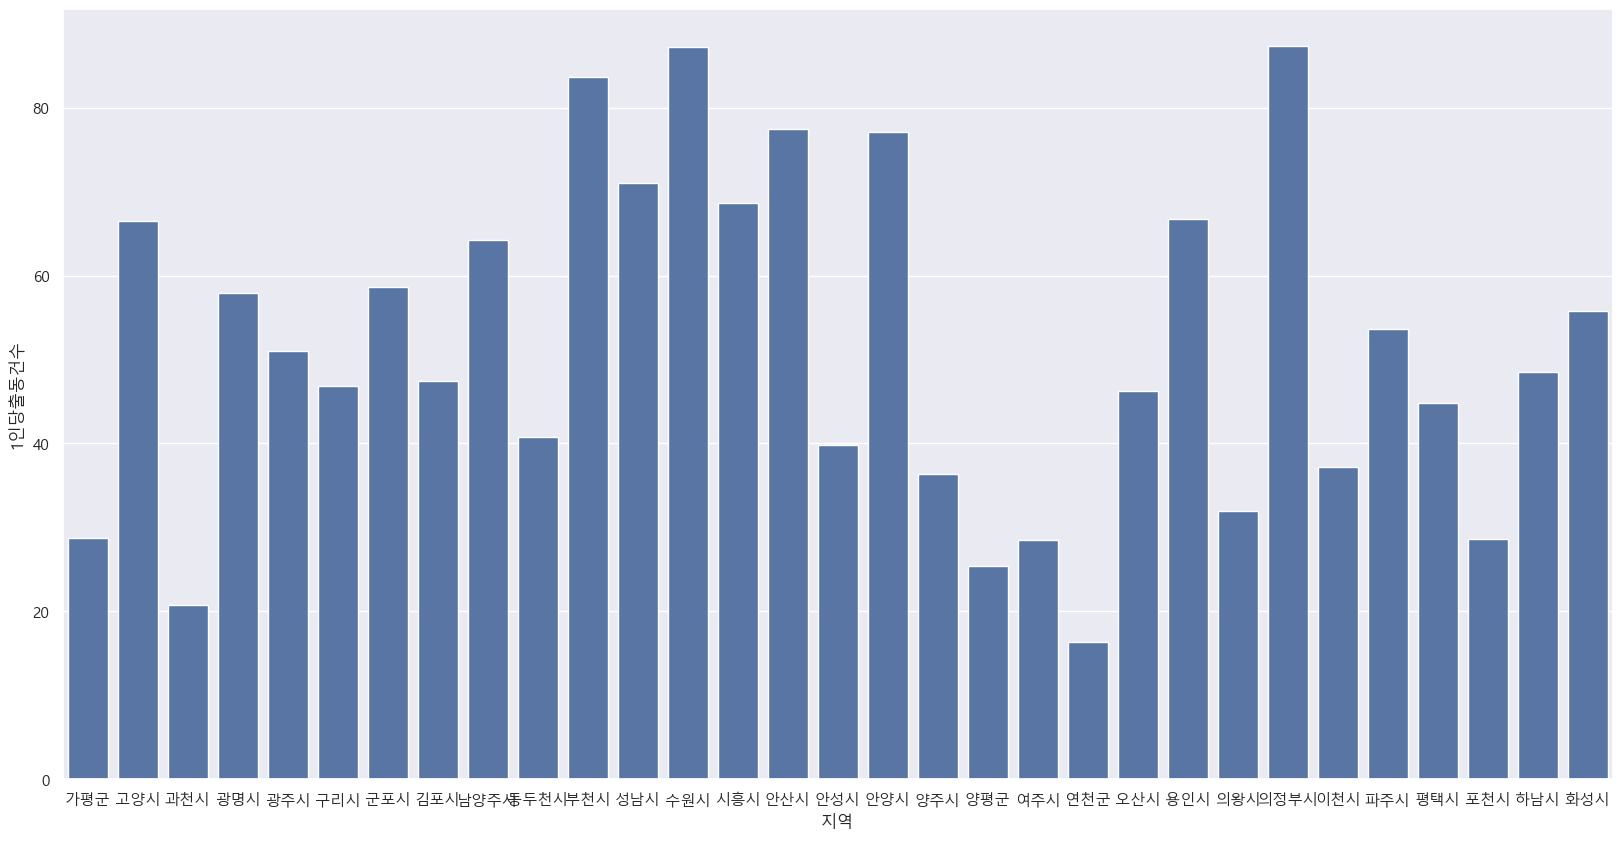

In [56]:
sns.barplot(data=f, x='지역', y='1인당출동건수', color='b')

In [57]:
f

,지역,1인/가구당,2인/가구당,3인/가구당,4인/가구당,5인/가구당,6인/가구당,7인 이상/가구당,총인구수,독거노인/노인,노인/전체,건수,정원(명),관할인구(명),1인당담당인구(명),1인당출동건수
0,가평군,33.271315,32.725287,17.541660,10.948876,3.971849,1.132503,0.408510,63936.0,0.304307,0.232060,6489,226,62264,276,28.712389
1,고양시,22.856842,25.887038,24.452592,20.772585,4.746723,1.026187,0.258033,1056853.0,0.230434,0.119979,41576,625,1079353,3449,66.521600
2,과천시,18.240711,24.461934,25.784345,24.167470,5.867866,1.054717,0.422957,58325.0,0.194366,0.133288,3122,150,73345,489,20.813333
3,광명시,22.068394,26.038126,24.238594,21.611465,4.851989,0.966811,0.224621,333114.0,0.231563,0.120085,12627,218,292893,1344,57.922018
4,광주시,22.625609,28.609487,23.278271,18.831774,5.124349,1.156471,0.374040,376819.0,0.215665,0.113946,15621,306,387289,1266,51.049020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,파주시,23.802492,26.867032,22.438939,19.840018,5.442904,1.254846,0.353770,463122.0,0.250651,0.125187,20972,391,483245,1236,53.636829
27,평택시,29.816892,25.767119,20.561942,17.810801,4.715329,1.026021,0.301896,518672.0,0.267111,0.113438,24628,549,564288,2045,44.859745
28,포천시,30.605238,30.222587,19.342660,13.920634,4.294573,1.194076,0.420233,163474.0,0.308381,0.161310,10600,370,148939,403,28.648649
29,하남시,23.879346,26.286615,23.426726,20.151097,5.015702,0.985706,0.254808,256760.0,0.287339,0.118180,10092,208,320087,1539,48.519231


<AxesSubplot:xlabel='지역', ylabel='1인당출동건수'>

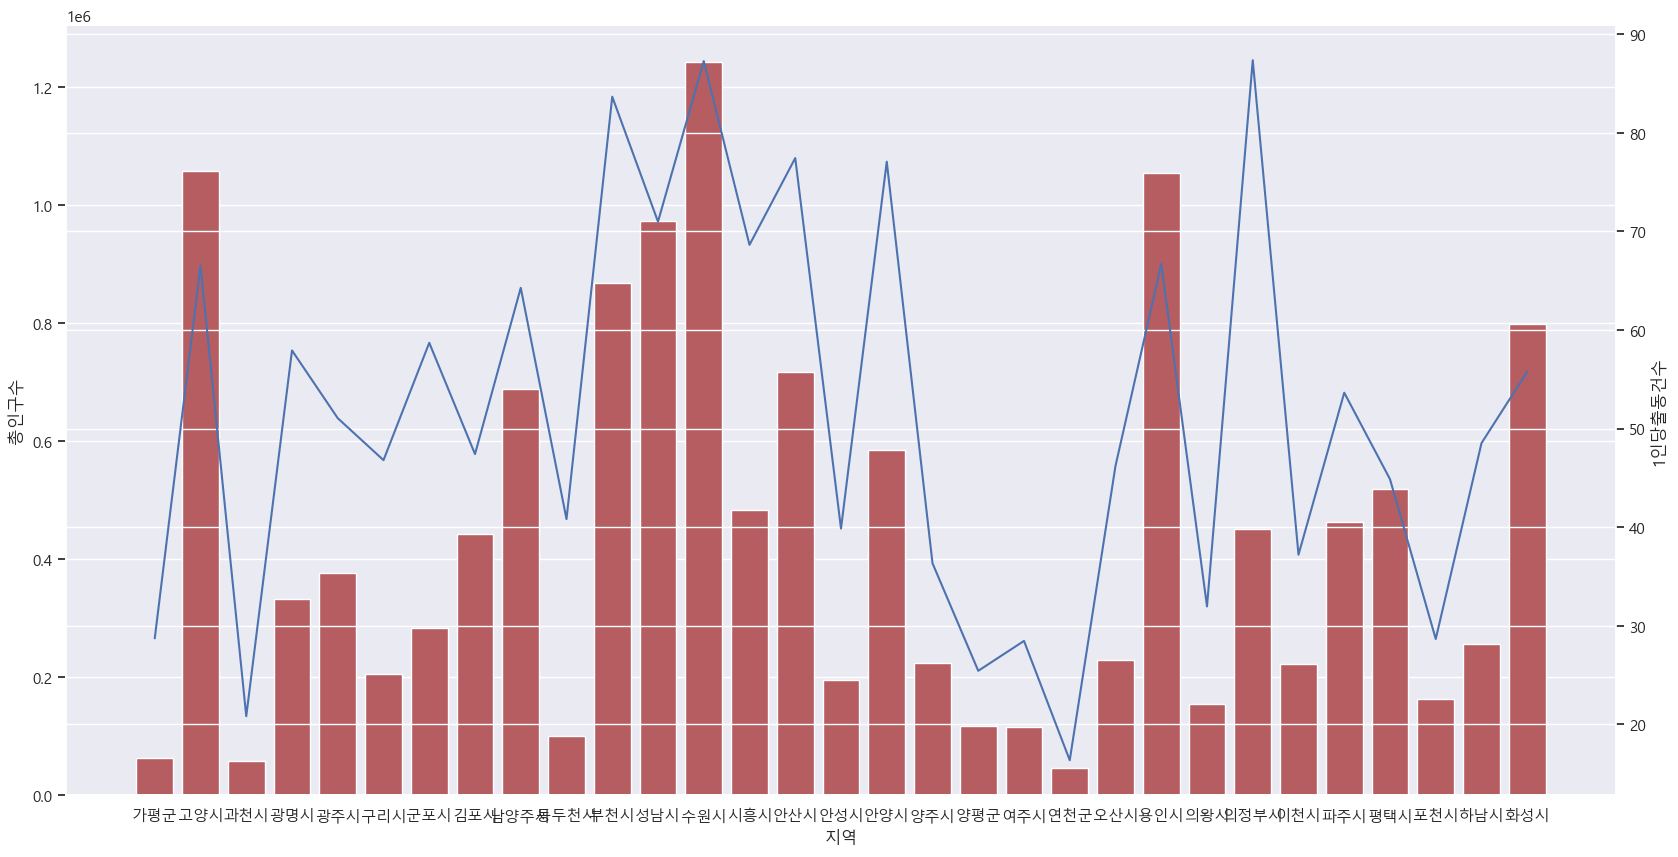

In [58]:
fig, ax = plt.subplots(1,1)

sns.barplot(data=f, x='지역', y='총인구수', ax=ax, color='r')

ax2 = ax.twinx()
sns.lineplot(data=f, x='지역', y='1인당출동건수', ax=ax2, color='b')

In [59]:
df = pd.merge(기초수급자, 독거노인비율, on='지역')
df = pd.merge(df, Y, on='지역')

In [60]:
df['1인당출동건수'] = df['지역별출동건수'] / df['총인구수']
df['기초수급자비율'] = df['기초수급자 수'] / df['총인구수']
sns.heatmap(df.corr(), annot=True)

KeyError: '지역별출동건수'

In [ ]:
df

,지역,기초수급자 수,총인구수,독거노인/노인,노인/전체,지역별출동건수,1인당출동건수,기초수급자비율
0,수원시,20478,1242212.0,0.294084,0.094866,51322,0.041315,0.016485
1,성남시,23921,972280.0,0.241298,0.123802,42876,0.044098,0.024603
2,안양시,10238,584239.0,0.209415,0.116095,22660,0.038785,0.017524
3,광명시,7730,333114.0,0.231563,0.120085,12627,0.037906,0.023205
4,평택시,12286,518672.0,0.267111,0.113438,24628,0.047483,0.023687
...,...,...,...,...,...,...,...,...
25,파주시,13080,463122.0,0.250651,0.125187,20972,0.045284,0.028243
26,양주시,7396,224250.0,0.254610,0.139046,11045,0.049253,0.032981
27,포천시,6121,163474.0,0.308381,0.161310,10600,0.064842,0.037443
28,연천군,2599,45606.0,0.329380,0.232930,3792,0.083147,0.056988
